In [11]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [12]:
df = pd.read_csv("/content/combined_data_with_date.csv")

In [13]:
# Starting date and time
start_datetime = pd.Timestamp('2024-01-01 00:00:00')

# Generating the exp_date column with 30-minute intervals
df['exp_date'] = [start_datetime + pd.Timedelta(minutes=30*i) for i in range(len(df))]


In [14]:
print(df.columns)

Index(['X1_ActualPosition', 'X1_ActualVelocity', 'X1_ActualAcceleration',
       'X1_CommandPosition', 'X1_CommandVelocity', 'X1_CommandAcceleration',
       'X1_CurrentFeedback', 'X1_DCBusVoltage', 'X1_OutputCurrent',
       'X1_OutputVoltage', 'X1_OutputPower', 'Y1_ActualPosition',
       'Y1_ActualVelocity', 'Y1_ActualAcceleration', 'Y1_CommandPosition',
       'Y1_CommandVelocity', 'Y1_CommandAcceleration', 'Y1_CurrentFeedback',
       'Y1_DCBusVoltage', 'Y1_OutputCurrent', 'Y1_OutputVoltage',
       'Y1_OutputPower', 'Z1_ActualPosition', 'Z1_ActualVelocity',
       'Z1_ActualAcceleration', 'Z1_CommandPosition', 'Z1_CommandVelocity',
       'Z1_CommandAcceleration', 'Z1_CurrentFeedback', 'Z1_DCBusVoltage',
       'Z1_OutputCurrent', 'Z1_OutputVoltage', 'S1_ActualPosition',
       'S1_ActualVelocity', 'S1_ActualAcceleration', 'S1_CommandPosition',
       'S1_CommandVelocity', 'S1_CommandAcceleration', 'S1_CurrentFeedback',
       'S1_DCBusVoltage', 'S1_OutputCurrent', 'S1_OutputVolt

In [15]:
df=df[['exp_date','X1_ActualPosition', 'X1_ActualVelocity', 'X1_ActualAcceleration',
       'X1_CommandPosition', 'X1_CommandVelocity', 'X1_CommandAcceleration',
       'X1_CurrentFeedback', 'X1_DCBusVoltage', 'X1_OutputCurrent',
       'X1_OutputVoltage', 'X1_OutputPower']]

In [16]:
# Create lag features
def create_lag_features(df, lag=1):
    df_lag = df.copy()
    for col in df.columns:
        if col != 'exp_date':
            for i in range(1, lag + 1):
                df_lag[f'{col}_lag{i}'] = df_lag[col].shift(i)
    df_lag.dropna(inplace=True)
    return df_lag


In [17]:
# Create lag features with a lag of 3
lag = 3
df_lag = create_lag_features(df.set_index('exp_date'), lag)

In [18]:
# Split the data into features and target
X = df_lag.drop(columns=['X1_OutputPower'])
y = df_lag['X1_OutputPower']

In [19]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [20]:
# Train the Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [22]:
# Predict on the training set
y_train_pred = rf.predict(X_train)
# Predict on the test set
y_test_pred = rf.predict(X_test)


In [25]:
# Evaluate the model on the training set
train_mse = mean_squared_error(y_train, y_train_pred)
# Evaluate the model on the test set
test_mse = mean_squared_error(y_test, y_test_pred)


In [26]:
print(f'Training Mean Squared Error: {train_mse}')


print(f'Testing Mean Squared Error: {test_mse}')


Training Mean Squared Error: 3.060637116758025e-08
Testing Mean Squared Error: 3.999865494789398e-08


<Figure size 1400x600 with 0 Axes>

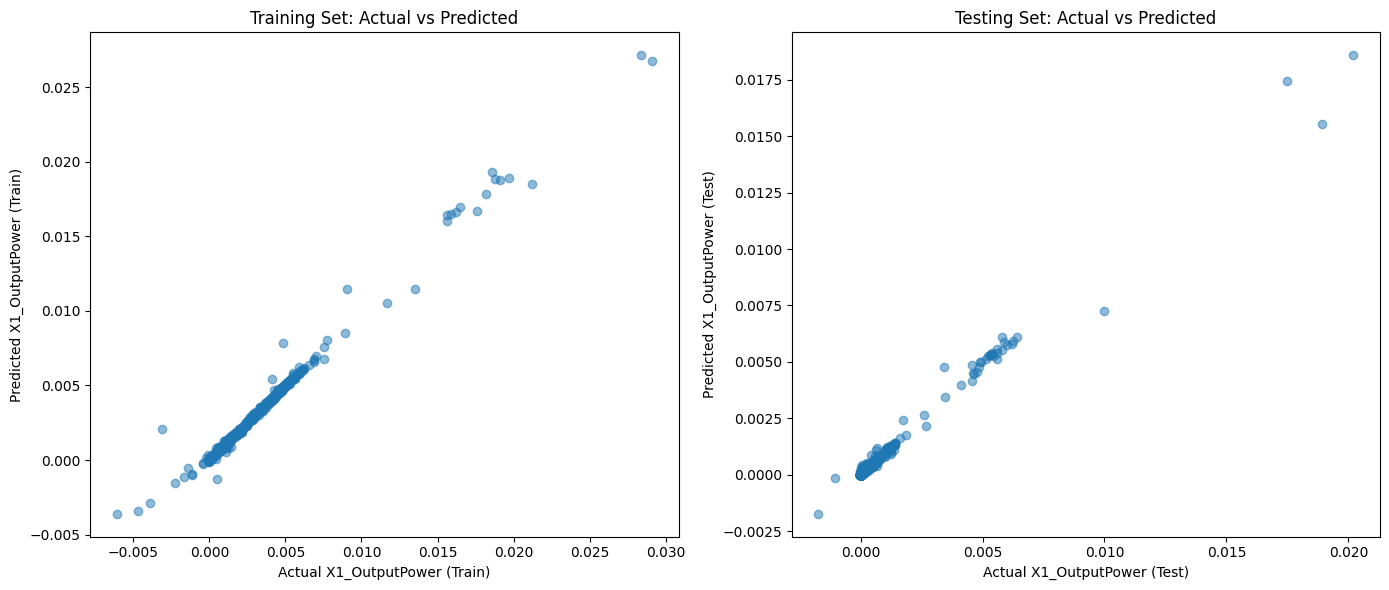

In [34]:
import matplotlib.pyplot as plt
# Plot the actual vs predicted values for training set
plt.figure(figsize=(14, 6))


plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, alpha=0.5)
plt.xlabel('Actual X1_OutputPower (Train)')
plt.ylabel('Predicted X1_OutputPower (Train)')
plt.title('Training Set: Actual vs Predicted')

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.xlabel('Actual X1_OutputPower (Test)')
plt.ylabel('Predicted X1_OutputPower (Test)')
plt.title('Testing Set: Actual vs Predicted')

plt.tight_layout()
plt.show()

Best parameters: {'max_depth': 20, 'n_estimators': 200}
Training Mean Squared Error: 3.089991617109738e-08
Testing Mean Squared Error: 3.2692120283727765e-08


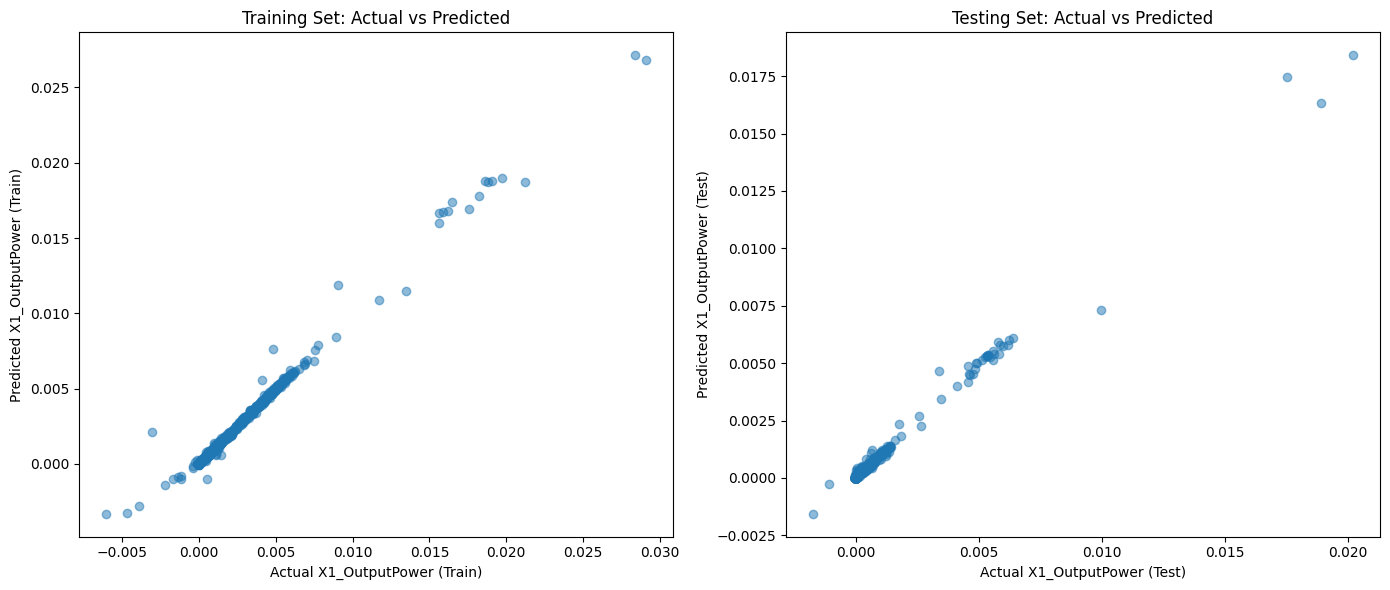

In [36]:
from sklearn.model_selection import train_test_split, GridSearchCV
# Create lag features with a lag of 3
lag = 3
df_lag = create_lag_features(df.set_index('exp_date'), lag)

# Split the data into features and target
X = df_lag.drop(columns=['X1_OutputPower'])
y = df_lag['X1_OutputPower']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20, None]
}

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f'Best parameters: {best_params}')

# Train the model with the best parameters
best_rf = RandomForestRegressor(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'], random_state=42)
best_rf.fit(X_train, y_train)

# Predict on the training set
y_train_pred = best_rf.predict(X_train)

# Predict on the test set
y_test_pred = best_rf.predict(X_test)

# Evaluate the model on the training set
train_mse = mean_squared_error(y_train, y_train_pred)


# Evaluate the model on the test set
test_mse = mean_squared_error(y_test, y_test_pred)


print(f'Training Mean Squared Error: {train_mse}')


print(f'Testing Mean Squared Error: {test_mse}')


# Calculate the residuals
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

# Plot the residuals for training set
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, alpha=0.5)
plt.xlabel('Actual X1_OutputPower (Train)')
plt.ylabel('Predicted X1_OutputPower (Train)')
plt.title('Training Set: Actual vs Predicted')

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.xlabel('Actual X1_OutputPower (Test)')
plt.ylabel('Predicted X1_OutputPower (Test)')
plt.title('Testing Set: Actual vs Predicted')


plt.tight_layout()
plt.show()


In [ ]:
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, alpha=0.5)
plt.xlabel('Actual X1_OutputPower (Train)')
plt.ylabel('Predicted X1_OutputPower (Train)')
plt.title('Training Set: Actual vs Predicted')

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.xlabel('Actual X1_OutputPower (Test)')
plt.ylabel('Predicted X1_OutputPower (Test)')
plt.title('Testing Set: Actual vs Predicted')


In [38]:

df = pd.read_csv("/content/combined_data_with_date.csv")
# Starting date and time
start_datetime = pd.Timestamp('2024-01-01 00:00:00')

# Generating the exp_date column with 30-minute intervals
df['exp_date'] = [start_datetime + pd.Timedelta(minutes=30*i) for i in range(len(df))]

df  = df[['exp_date','Y1_ActualPosition',
       'Y1_ActualVelocity', 'Y1_ActualAcceleration', 'Y1_CommandPosition',
       'Y1_CommandVelocity', 'Y1_CommandAcceleration', 'Y1_CurrentFeedback',
       'Y1_DCBusVoltage', 'Y1_OutputCurrent', 'Y1_OutputVoltage',
       'Y1_OutputPower',
                ]]

In [39]:
# Create lag features with a lag of 3
lag = 3
df_lag = create_lag_features(df.set_index('exp_date'), lag)

In [41]:
# Split the data into features and target
X = df_lag.drop(columns=['Y1_OutputPower'])
y = df_lag['Y1_OutputPower']

In [42]:
# Train the model with the best parameters
best_rf = RandomForestRegressor(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'], random_state=42)
best_rf.fit(X, y)


RandomForestRegressor(max_depth=20, n_estimators=200, random_state=42)

In [44]:

# Predict on the training set
y_pred = best_rf.predict(X)
# Evaluate the model on the test set
mse = mean_squared_error(y, y_pred)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 1.1334397595250711e-08


Text(0.5, 1.0, 'Training Set: Actual vs Predicted')

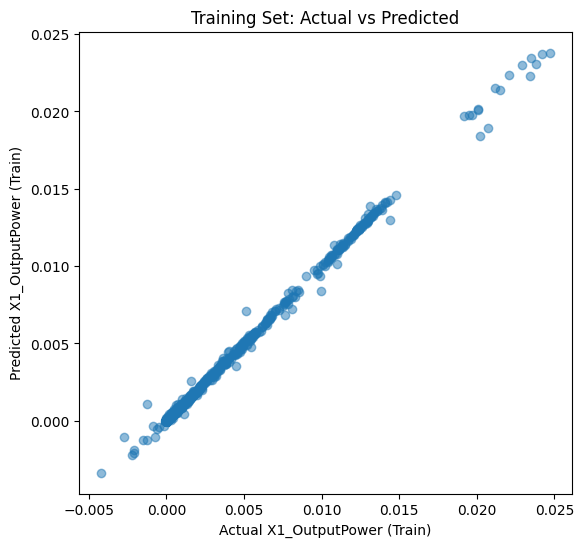

In [45]:

# Plot the residuals for training set
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.scatter(y, y_pred, alpha=0.5)
plt.xlabel('Actual X1_OutputPower (Train)')
plt.ylabel('Predicted X1_OutputPower (Train)')
plt.title('Training Set: Actual vs Predicted')
